In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install torch
import torch

Prescient autoencoder 5
This notebook implements part of the [prescient model](https://docs.google.com/drawings/d/1czjcBtDQGS8X6bnIbYU4wmFvv1AfZt5wwSRk9oyQGw0/edit). Here we continue where we left off in [part 3](https://colab.research.google.com/drive/1mbhRqsRV5RvFZgMPdG1DOxCBUpXh118M#scrollTo=KuP7C7pUOZPO&uniqifier=10).

Try without the pdfs, just simple autoencoder with prescient input

## Basics

In [0]:
import math
import logging
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import pdb
import numpy as np
import random
from scipy.ndimage.filters import gaussian_filter
from scipy import stats
from scipy.stats import norm
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from skimage.draw import line_aa
%matplotlib inline
plt.style.use('classic')

device = "cuda" if torch.cuda.is_available() else "cpu"
logging.basicConfig(
    level=logging.ERROR,
    format='%(asctime)s.%(msecs)03d %(name)s:%(funcName)s %(levelname)s:%(message)s',
    datefmt="%M:%S")

# TODO: Use torch.normal(mean, std=1.0, out=None) 
class NormalDistributionTable(object):
    def __init__(self, resolution, var=0.07, table_resolution=100):
      self.resolution = resolution
      self.var = var
      self.table_resolution = table_resolution
      self.gaussians = torch.tensor([norm.pdf(np.arange(0, 1, 1.0 / self.resolution), mean, self.var) for mean in np.linspace(0, 1, self.table_resolution)])
      self.gaussians = self.gaussians.transpose(0, 1)
      self.gaussians = self.gaussians / self.gaussians.sum(dim=0)
      self.gaussians = self.gaussians.transpose(0, 1)

    def lookup(self, mean):
      assert mean >= 0 and mean <= 1, "mean must be between 0 and 1"
      index = math.floor(mean * self.table_resolution)
      if index == self.table_resolution:
        index = self.table_resolution - 1
      return self.gaussians[index]

    def to_pdf(self, images):
      element_count = np.prod(images.shape)
      images_shape = images.shape
      images_view = images.contiguous().view((element_count,))
      images_pdf = torch.stack([self.lookup(mean.item()) for mean in images_view])
      images_pdf = images_pdf.view(images_shape[:-1] + (images_shape[-1] * self.resolution, ))
      return images_pdf


def generate_images(width, height, count=100):
    images = []
    for _ in range(100):
        image = np.zeros((width, height))
        rr, cc, val = line_aa(random.randint(0, height-1), random.randint(0, width-1), random.randint(0, height-1), random.randint(0, width-1))
        image[rr, cc] = val
        image=gaussian_filter(image, 0.5)
        images.append(image)

    return torch.as_tensor(images).to(device)

def generate_moving_line(width, height, count=100):
  images = []
  for i in range(int(count/2)):
    image = np.zeros((width, height))
    rr, cc, val = line_aa(2, 3-i, width-2, height-1-i)
    image[rr, cc] = val
    image=gaussian_filter(image, 0.5)
    images.append(image)

  for i in range(int(count/2)):
    image = np.zeros((width, height))
    rr, cc, val = line_aa(width-1-i, 2-i, 4-i, height-2-i)
    image[rr, cc] = val
    image=gaussian_filter(image, 0.5)
    images.append(image)

  return torch.as_tensor(images).to(device)

def generate_bouncing_pixel(width, height, count=100):
  ball_width = 2
  x = random.randint(0, width)
  y = random.randint(0, height)
  dx = 1
  dy = 1
  
  images = []
  for _ in range(count):
    image = np.zeros((width, height))
    image[x, y] = 1
    image[x+1, y] = 1
    image[x, y+1] = 1
    image[x+1, y+1] = 1

    #image=gaussian_filter(image, 0.5)
    images.append(image)
    x += dx
    y += dy
    if (x < 0 or x > width - 1 - (ball_width - 1)):
      dx *= -1
      x += dx
    if (y < 0 or y > height - 1 - (ball_width - 1)):
      dy *= -1
      y += dy

  return torch.as_tensor(images).to(device)
    
def show_image(image, vmin=None, vmax=None, title=None, print_values=False, figsize=(4, 4)):
    #print("image ", image.shape)
    image = image.cpu().numpy()
    fig, ax1 = plt.subplots(figsize=figsize)
    if title:
        plt.title(title)
    #i = image.reshape((height, width))
    #print("i ", i.shape)
    ax1.imshow(image, vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma)
    plt.show()
    if print_values:
        print(image)
        
def sample_from_pdf1(pdf):
    assert pdf.shape == (resolution, )

    pk = pdf.copy()
    xk = np.arange(resolution)
    pk[pk<0] = 0
    sum_pk = sum(pk)
    if sum(pk) > 0:
        pk = pk / sum_pk
        custm = stats.rv_discrete(name='custm', values=(xk, pk))
        value = custm.rvs(size=1) / resolution
        # apply scale (conflates value and confidence!)
        value = value * sum_pk
        return value
    else:
        return [0]

def sample_from_pdf(pdf):
    assert pdf.shape == (resolution, )
    #print("pdf ", pdf)

    sum_pdf = sum(pdf)
    #print("sum_pdf ", sum_pdf)

    if sum_pdf > 0:
        v = random.random()
        #print("v ", v)

        s = 0
        index = 0
        while s < v and index < resolution:
          s += pdf[index] / sum_pdf
          index += 1
          #print("  s ", s)
          #print("  index ", index)
          
        # apply scale (conflates value and confidence!)
        return [(index - 1) * sum_pdf / resolution]
    else:
        return [0]


def sample_from_images__(images__):
    assert len(images__.shape) == 3

    # reshape images__ from (image count, height, width*resolution) into (image count*height*width, resolution)
    s = images__.shape
    flattened_images__ = images__.view(s[0], s[1], int(s[2] / resolution), resolution)
    s = flattened_images__.shape
    flattened_images__ = flattened_images__.view(s[0] * s[1] * s[2], s[3])

    # sample single value from each distributions into (image count*height*width, 1)
    sampled_pixels = torch.Tensor([sample_from_pdf(item.cpu().numpy()) for item in flattened_images__])

    # reshape back into (image count, height, width)
    sampled_images = sampled_pixels.view(s[0], s[1], s[2])

    return sampled_images


def averaged_sample_from_images__(images__, count=10):
    sampled_images = torch.stack([sample_from_images__(images__) for i in range(count)])
    return sampled_images.mean(dim=0)


def aggregate_to_pdf(mu_bar, image_count, samples_per_image, iH, iW, resolution):
  #print("aggregate_to_pdf mu_bar", mu_bar.shape)
  # mu_bar                          (image_count * samples_per_image, iH, iW)
  # mu_bar_per_image                (image_count,  samples_per_image, iH, iW)
  mu_bar = mu_bar.clamp(0, 1)
  mu_bar_per_image = mu_bar.view(image_count, samples_per_image, iH, iW)

  # mu_bar_per_image_flattened      (image_count,  iH,  iW, samples_per_image)
  mu_bar_per_image_flattened = mu_bar_per_image.permute(0, 2, 3, 1).contiguous()
  # mu_bar_per_image_flattened      (image_count * iH * iW, samples_per_image)
  mu_bar_per_image_flattened = mu_bar_per_image_flattened.view(image_count * iH * iW, samples_per_image)


  # mu_bar_flattened__              (image_count * iH * iW, resolution)
  mu_bar_flattened__ = torch.zeros((image_count * iH * iW, resolution))
  assert mu_bar_per_image_flattened.shape[0] == mu_bar_flattened__.shape[0]

  for sample_index in range(samples_per_image):
    #print("mu_bar_per_image_flattened[:, sample_index] ", mu_bar_per_image_flattened[:, sample_index])
    histogram_indices = (mu_bar_per_image_flattened[:, sample_index] * resolution).long().cpu()
    for item_index in range(mu_bar_per_image_flattened.shape[0]): # TODO: Vectorize!
      mu_bar_flattened__[item_index][histogram_indices[item_index]] += 1

  # mu_bar__                        (image_count, iH, iW * resolution)
  mu_bar__ = mu_bar_flattened__.view((image_count, iH, iW,  resolution))
  mu_bar__ = torch.nn.functional.normalize(mu_bar__, p=1, dim=3)
  mu_bar__ = mu_bar__.view(          (image_count, iH, iW * resolution))

  return mu_bar__

# Assume input (samples, feature maps, height, width) and that 
# features maps is a perfect squere, e.g. 9, of an integer 'a', e.g. 3 in this case
# Output (samples, height * a, width * a)
def flatten_feature_maps(f):
    s = f.shape
    f = f.permute(0, 2, 3, 1) # move features to the end
    s = f.shape
    a = int(s[3] ** 0.5)  # feature maps are at pos 3 now that we want to first split into a square of size (a X a)
    assert a * a == s[3], "Feature map count must be a perfect square"
    f = f.view(s[0], s[1], s[2], a, a)
    f = f.permute(0, 1, 3, 2, 4).contiguous() # frame count, height, sqr(features), width, sqr(features)
    s = f.shape
    f = f.view(s[0], s[1] * s[2], s[3] * s[4]) # each point becomes a square of features
    return f
  
# Assume input (samples, height * a, width * a)
# Output (samples, feature maps, height, width)
def unflatten_feature_maps(f, a):
    s = f.shape
    f = f.view(s[0], int(s[1] / a), a, int(s[2] / a), a)
    
    f = f.permute(0, 1, 3, 2, 4).contiguous() # move features to the end
    s = f.shape
    f = f.view(s[0], s[1], s[2], a * a).permute(0, 3, 1, 2)
    return f

class EMA:
  def __init__(self, mu):
    super(EMA, self).__init__()
    self.mu = mu

  def forward(self,x, last_average):
    new_average = self.mu*x + (1-self.mu)*last_average
    return new_average
  

resolution = 10
var = 0.02
normal_distribution_table = NormalDistributionTable(resolution=resolution, var=var)


## Autoencoder

In [0]:
class Flatten2D(nn.Module):
  def __init__(self, a=3):
    super(Flatten2D, self).__init__()

  def forward(self, x):
    x = flatten_feature_maps(x)
    return x

class Encoder(nn.Module):
  def __init__(self, autoencoder_index, a=4):
    super(Encoder, self).__init__()
    self.autoencoder_index = autoencoder_index
    self.a = a
    self.conv = nn.Conv2d(1, a * a, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(a * a, 1, 3, stride=1, padding=1)

    self.maxpool = nn.MaxPool2d(2, stride=2)
    self.flatten2d = Flatten2D()
    self.logger = logging.getLogger(self.__class__.__name__)
    self.logger.setLevel(logging.DEBUG)

  def forward(self, x):
    x = x[:, None, :, :]
    self.logger.debug(x.shape)
    x = F.relu(self.conv(x))
    self.logger.debug(x.shape)
    x = self.maxpool(x)
    self.logger.debug(x.shape)
    x = self.conv2(x)
    #x = self.flatten2d(x)
    self.logger.debug(x.shape)
    x = torch.sigmoid(x)[:, 0, :, :]
    self.logger.debug(x.shape)
    
    self.output = x
    return x
  
class Decoder(nn.Module):
  def __init__(self, autoencoder_index, a=4):
    super(Decoder, self).__init__()
    self.autoencoder_index = autoencoder_index
    self.a = a
    self.conv_transpose = nn.ConvTranspose2d(1, 1, 3, stride=2, d=1, output_padding=1)
    #self.conv1 = nn.Conv2d(1, a * a, a * 3, stride=1, padding=1)
    #self.conv2 = nn.Conv2d(a * a, 1, a * 3, stride=1, padding=1)

    self.maxpool = nn.MaxPool2d(2, stride=2)
    self.logger = logging.getLogger(self.__class__.__name__)
    self.logger.setLevel(logging.DEBUG)
    
  def forward(self, x):
    x = x[:, None, :, :]
    self.logger.debug(x.shape)
    x = torch.relu(self.conv_transpose(x))
    self.logger.debug(x.shape)

    #x = F.relu(self.conv1(x))
    #self.logger.debug(x.shape)
#     x = self.maxpool(x)
#     self.logger.debug(x.shape)

    #x = F.relu(self.conv2(x))
    #self.logger.debug(x.shape)
#     x = self.maxpool(x)
#     self.logger.debug(x.shape)

    x = torch.sigmoid(x)[:, 0, :, :]
    self.logger.debug(x.shape)
    return x

class AutoEncoder:
  def __init__(self, autoencoder_index, a=4):
    super(AutoEncoder, self).__init__()
    self.a = a
    self.autoencoder_index = autoencoder_index
    self.encoder = Encoder(autoencoder_index, a)
    self.decoder = Decoder(autoencoder_index, a)
    self.encoder_output = None

class Network(nn.Module):
  def __init__(self, a=4):
    super(Network, self).__init__()
    self.ae0 = AutoEncoder(0, a)
    self.add_module("ae0_encoder", self.ae0.encoder)
    self.add_module("ae0_decoder", self.ae0.decoder)
    
  def forward(self, x):
    x = self.ae0.encoder(x)
    x = self.ae0.decoder(x)
    return x

  def train(self, mu1, num_epochs=3000):
    learning_rate = 1e-3
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate,
                                 weight_decay=1e-5)

    input = mu1.float().to(device)

    done = False
    epoch = 0
    while not done:
      output = self(input)
      loss = criterion(output, input)
      # ===================backward====================
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if epoch % int(num_epochs / 10) == 0:
        print('epoch [{}/{}], loss:{:.4f}'
             .format(epoch+1, num_epochs, loss.item()))
        show_image(self.ae0_encoder.output[0].detach(), title=f"encoder output {0}", vmin=0, vmax=1)
        show_image(output[0].detach(), title=f"output {0}", vmin=0, vmax=1)

      if (loss.item() < 0.001 and epoch > 1500) or epoch > num_epochs:
        done = True

      epoch += 1
      torch.save(self.state_dict(), self.save_path())

    print("output", output.shape)
    #output = output[:,0,:,:]
    show_image(output[0].detach(), title=f"output {0}", vmin=0, vmax=1)
    return output

  def save_path(self):
    return f"network.pt"



## Example

20:42.096 Encoder:forward DEBUG:torch.Size([20, 1, 16, 16])
20:42.098 Encoder:forward DEBUG:torch.Size([20, 16, 16, 16])
20:42.100 Encoder:forward DEBUG:torch.Size([20, 16, 8, 8])
20:42.101 Encoder:forward DEBUG:torch.Size([20, 1, 8, 8])
20:42.103 Encoder:forward DEBUG:torch.Size([20, 8, 8])
20:42.104 Decoder:forward DEBUG:torch.Size([20, 1, 8, 8])
20:42.105 Decoder:forward DEBUG:torch.Size([20, 1, 16, 16])
20:42.106 Decoder:forward DEBUG:torch.Size([20, 16, 16])


epoch [1/3000], loss:0.2741


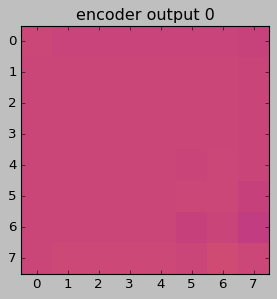

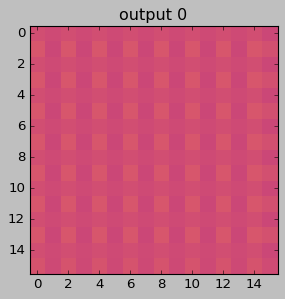

20:42.458 Encoder:forward DEBUG:torch.Size([20, 1, 16, 16])
20:42.459 Encoder:forward DEBUG:torch.Size([20, 16, 16, 16])
20:42.460 Encoder:forward DEBUG:torch.Size([20, 16, 8, 8])
20:42.461 Encoder:forward DEBUG:torch.Size([20, 1, 8, 8])
20:42.463 Encoder:forward DEBUG:torch.Size([20, 8, 8])
20:42.464 Decoder:forward DEBUG:torch.Size([20, 1, 8, 8])
20:42.466 Decoder:forward DEBUG:torch.Size([20, 1, 16, 16])
20:42.467 Decoder:forward DEBUG:torch.Size([20, 16, 16])
20:42.474 Encoder:forward DEBUG:torch.Size([20, 1, 16, 16])
20:42.475 Encoder:forward DEBUG:torch.Size([20, 16, 16, 16])
20:42.476 Encoder:forward DEBUG:torch.Size([20, 16, 8, 8])
20:42.477 Encoder:forward DEBUG:torch.Size([20, 1, 8, 8])
20:42.478 Encoder:forward DEBUG:torch.Size([20, 8, 8])
20:42.479 Decoder:forward DEBUG:torch.Size([20, 1, 8, 8])
20:42.481 Decoder:forward DEBUG:torch.Size([20, 1, 16, 16])
20:42.482 Decoder:forward DEBUG:torch.Size([20, 16, 16])
20:42.488 Encoder:forward DEBUG:torch.Size([20, 1, 16, 16])
20:4

KeyboardInterrupt: ignored

In [0]:
image_size = 16
image_count = 20
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

mu1 = generate_bouncing_pixel(image_size, image_size, count=image_count)

network = Network(a=4).to(device)
mu1_bar = network.train(mu1)

for i in range(mu1_bar.shape[0]):
  show_image(mu1[i].detach(), title=f"mu1 {i}", vmin=0, vmax=1)
  show_image(mu1_bar[i].detach(), title=f"mu1_bar {i}", vmin=0, vmax=1)


In [0]:
import os
import glob

files = glob.glob('./*.pt')
for f in files:
    os.remove(f)